In [40]:
import numpy as np
import pandas as pd
import seaborn as sns

import healpy as hp
from tqdm import tqdm, tqdm_notebook
import scipy as sp
from scipy.special import erf
from scipy import stats

import sys
from my_units import * 

from angular_fn import *
from template_fn import *
from cov_matrix_fn import *

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable


'''plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors

rcParams['mathtext.rm'] = 'Computer Modern'
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
'''

HomeDir = './'
DataDir = '/Users/crimondino/Dropbox (PI)/LensVelocity2/data/pairs_ruwe_dist/'#HomeDir #+ 'code/'
### Set this to the directory where you store your data files (see below how to download them)
ListDir = HomeDir+'lists/hist_stats/'
FigDir = '../../../figures/'

In [39]:
from IPython.core.display import display, HTML
from IPython.display import display, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(edgeitems=3, linewidth=200) 
pd.set_option('display.max_columns', None)
pd.set_option('max_rows',200) and pandas.set_option('max_columns',20)

In [37]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
rcParams['mathtext.rm'] = 'Times New Roman' 
rcParams['text.usetex'] = True
rcParams['font.family'] = 'times' #'sans-serif'

font_manager.findfont('serif', rebuild_if_missing=True)
fontsize = 14
rcParams.update({'font.size':fontsize})

# Read in files

In [2]:
#df_back = pd.read_csv(DataDir+'pairs_background_ruwe_w_st.csv', usecols = ['source_id', 'ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'pmra_pmdec_corr', 'pmra_eff_error', 'pmdec_eff_error', 'pmra_pmdec_eff_corr', 'parallax', 'parallax_error', 'pmra_sub', 'pmdec_sub', 'phot_g_mean_mag', 'ruwe'])
#print('Backgrounds read in.')

#df_fore = pd.read_csv(DataDir+'pairs_foreground_ruwe_w_st.csv', usecols = ['source_id', 'ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'parallax', 'parallax_error', 'phot_g_mean_mag', 'ruwe'])
#print('Foregrounds read in.')

In [3]:
### Read in the data files for the background and foreground stars
df_back = pd.read_csv(DataDir+'bg_ruwe_dist.csv', 
                      usecols = ['source_id', 'ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'pmra_pmdec_corr', 'pmra_eff_error', 'pmdec_eff_error', 'pmra_pmdec_eff_corr', 
                                 'parallax', 'parallax_error', 'pmra_sub', 'pmdec_sub', 'phot_g_mean_mag', 'ruwe'])
df_fore = pd.read_csv(DataDir+'fg_ruwe_dist.csv', 
                      usecols = ['source_id', 'ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'parallax', 'parallax_error', 'phot_g_mean_mag', 'ruwe']) #, 'ecl_lon', 'ecl_lat'])
len(df_back), len(df_fore)

(10448136, 10448136)

In [76]:
bright_back =  df_back['phot_g_mean_mag'].to_numpy() < 10
lens_factor = (1-fore_dist[bright_back]['1']/back_dist[bright_back]['1']).to_numpy()

In [77]:
len(lens_factor[lens_factor > 0.5])

54

In [4]:
### Read in the data files for the Bailer-Jones distances
back_dist = pd.read_csv(DataDir+'bg_distances.csv', usecols = ['0', '1', '2', '3'])
fore_dist = pd.read_csv(DataDir+'fg_distances.csv', usecols = ['0', '1', '2', '3'])
len(back_dist), len(fore_dist)

(10448136, 10448136)

In [18]:
back_dist

,0,1,2,3
0,8246337986176,3971.99850,3198.10550,5133.20750
1,17390323414400,487.26510,477.90253,496.88528
2,44362718024064,2344.73300,1347.35780,3834.37600
3,45664092292480,394.70175,392.11835,397.17258
4,116479513433472,289.37510,280.17908,296.92358
...,...,...,...,...
10448131,6917478140870742912,626.69495,587.05896,667.95590
10448132,6917489002841912192,2321.53700,1403.91750,3485.24400
10448133,6917515936580935168,1829.88760,1477.00330,2262.95070
10448134,6917516245821046528,2862.99660,1695.03850,5492.02640


# Density plot

In [5]:
eq_to_gal_rot_matrix = np.array([[-0.0548755604162154, -0.8734370902348850, -0.4838350155487132], 
                                 [0.4941094278755837, -0.4448296299600112, 0.7469822444972189], 
                                 [-0.8676661490190047, -0.1980763734312015, 0.4559837761750669]])

def fn_eq_to_gal_array(ra, dec):
    """
    Function to convert the equatorial coordinates (ra, dec) to galactic coordinates according to the Gaia reference frame.
    Works only if ra and dec are numpy arrays. Takes angles in degree and returns in degree.
    Refs.: https://gea.esac.esa.int/archive/documentation/GEDR3/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html 
    and section 1.5.3 of https://www.cosmos.esa.int/documents/532822/552851/vol1_all.pdf
    """
    
    ra_s, dec_s = ra*degree, dec*degree
    
    x_vec_eq = np.array([np.cos(dec_s)*np.cos(ra_s), np.cos(dec_s)*np.sin(ra_s), np.sin(dec_s)])
    x_vec_gal = (eq_to_gal_rot_matrix @ x_vec_eq).T
    
    gal_lon, gal_lat = (np.arctan2(x_vec_gal[:, 1], x_vec_gal[:, 0])), np.arctan2(x_vec_gal[:, 2], np.sqrt(x_vec_gal[:, 0]**2 + x_vec_gal[:, 1]**2))
    gal_lon = gal_lon + 2*np.pi*np.heaviside(-gal_lon, 0) ### shift the interval from [-pi, pi] to [0, 2*pi]

    return gal_lon/degree, gal_lat/degree

In [45]:
nside = 2**7
npix = hp.nside2npix(nside)
print('nside =',nside,', npix =',npix)
print('linear pixel size =',str(np.sqrt(4*np.pi / npix) / degree)[0:7],' degree')

nside = 128 , npix = 196608
linear pixel size = 0.45806  degree


In [8]:
fore_l, fore_b = fn_eq_to_gal_array(df_fore['ra'].to_numpy(), df_fore['dec'].to_numpy())
back_l, back_b = fn_eq_to_gal_array(df_back['ra'].to_numpy(), df_back['dec'].to_numpy())

In [9]:
q_pix_1 = hp.ang2pix(nside,fore_l,fore_b,lonlat=True)
q_pix_2 = hp.ang2pix(nside,back_l, back_b,lonlat=True)
pix_coords = np.asarray(hp.pixelfunc.pix2ang(nside,np.arange(npix))).transpose()

In [10]:
map_count_1 = np.zeros(hp.nside2npix(nside));
map_count_2 = np.zeros(hp.nside2npix(nside));
for idx, ipix in tqdm(enumerate(q_pix_1)):
    map_count_1[ipix] += 1
#for idx, ipix in tqdm(enumerate(q_pix_2)):
#    map_count_2[ipix] += 1

10448136it [00:07, 1404783.60it/s]


/Users/crimondino/.local/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(
<ipython-input-41-57f538c85ca3>:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(FigDir+'pairs_map.pdf',figsize=(8,6),bbox_inches='tight')#,bbox_extra_artists=(image,)',dpi=300,)


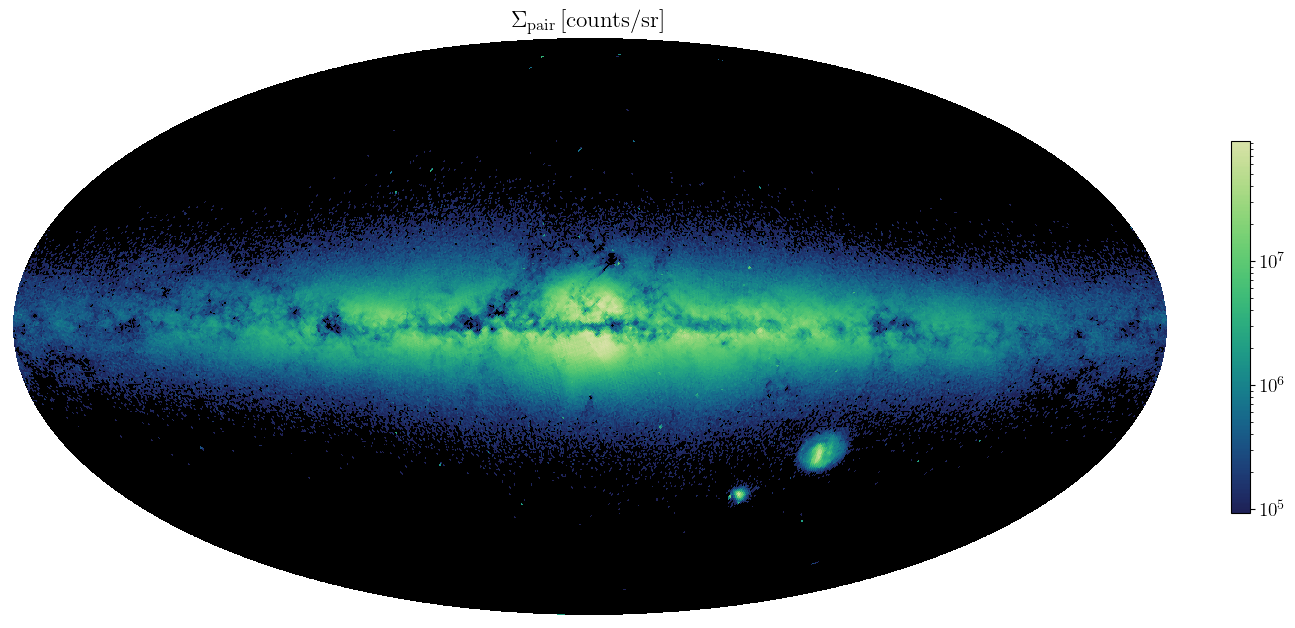

In [41]:
map = 1e-10 + map_count_1 / (hp.pixelfunc.nside2resol(nside))**2 
map_min = 1e-3 * np.max(map); map_max = np.max(map); 
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
cmap = sns.cubehelix_palette(start = 0.25, hue = 1.5, rot = -2/3, reverse = True, as_cmap=True)
#cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
cmap.set_under(cmap(0)); cmap.set_bad(cmap(0)); cmap.set_over(cmap(1));
#cmap.set_under('white'); cmap.set_over('black')
plt.subplots(1,1,figsize=(16,8))
hp.mollview(map, title=r'$\Sigma_\mathrm{pair} \, [\mathrm{counts/sr}]$',  #title=r"Pair density (foreground) $\Sigma_\mathrm{pair}$", 
            cmap=cmap,cbar=None, 
            bgcolor='black',badcolor='white',
            min=map_min,max=map_max,
            xsize=5000,hold=True,
            norm=mpl.colors.LogNorm(vmin=map_min,vmax=map_max))
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar = fig.colorbar(image, ax=ax,fraction=0.015);
#cbar.set_label(r'$\Sigma_\mathrm{pair} \, [\mathrm{counts/sr}]$', fontsize=16)

#mpl.rcParams.update({'font.size': 16})

fig.savefig(FigDir+'pairs_map.pdf',figsize=(8,6),bbox_inches='tight') #,bbox_extra_artists=(image,)',dpi=300,)

# Quality cuts

In [5]:
max_ruwe = 1.4

df_fore = df_fore[df_back['ruwe'] < max_ruwe]
back_dist = back_dist[df_back['ruwe'] < max_ruwe]
fore_dist = fore_dist[df_back['ruwe'] < max_ruwe]

df_back = df_back[df_back['ruwe'] < max_ruwe]


df_back = df_back[df_fore['ruwe'] < max_ruwe]
back_dist = back_dist[df_fore['ruwe'] < max_ruwe]
fore_dist = fore_dist[df_fore['ruwe'] < max_ruwe]

df_fore = df_fore[df_fore['ruwe'] < max_ruwe]


print(len(df_fore))

10448136


In [6]:
back_dist_med = back_dist['1'].to_numpy()
back_dist_lo = back_dist['2'].to_numpy()
back_dist_hi = back_dist['3'].to_numpy()

fore_dist_med = fore_dist['1'].to_numpy()
fore_dist_lo = fore_dist['2'].to_numpy()
fore_dist_hi = fore_dist['3'].to_numpy()

nsigma = 2
condition = fore_dist_med + nsigma * (fore_dist_hi - fore_dist_med) < back_dist_med - nsigma * (back_dist_med - back_dist_lo)

df_fore = df_fore[condition]
df_back = df_back[condition]

fore_dist = fore_dist[condition]
back_dist = back_dist[condition]

back_dist_med = back_dist['1'].to_numpy()
back_dist_lo = back_dist['2'].to_numpy()
back_dist_hi = back_dist['3'].to_numpy()

fore_dist_med = fore_dist['1'].to_numpy()
fore_dist_lo = fore_dist['2'].to_numpy()
fore_dist_hi = fore_dist['3'].to_numpy()
print(len(df_fore))

10448135


In [7]:
df_back['dist'] = back_dist_med
# take average of posterior widths
df_back['dist_error'] = ((back_dist_med - back_dist_lo) + (back_dist_hi - back_dist_med)) / 2

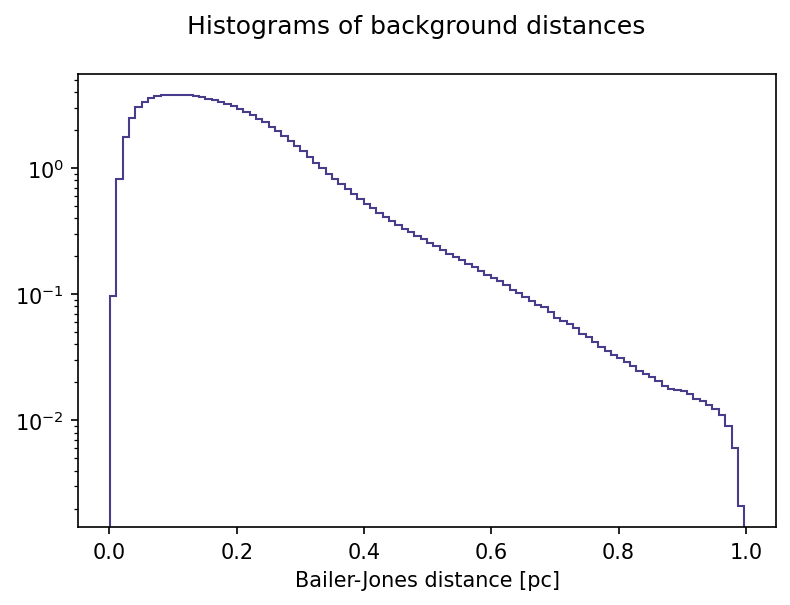

In [8]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
ax.hist(fore_dist['1']/back_dist['1'], log = True,  density = True, bins = 100, histtype='step', color = 'darkslateblue')
ax.set_xlabel(r'Bailer-Jones distance [pc]')
fig.suptitle('Histograms of background distances')
plt.show()

# Binning in location, distance, $G$-magnitude, and angular separation

## Import bin definitions

In [9]:
from bin_defs import *

hp.nside2npix(hp.order2nside(n)), len(bins_dist), len(bins_G), len(bins_bil)

(3072, 7, 14, 12)

In [10]:
(hp.nside2npix(hp.order2nside(n))-1) * (len(bins_dist)-1) * (len(bins_G)-1) * (len(bins_bil)-1)

2634918

## Bin assignments

In [11]:
### Get the pixel bin index for the background stars
q_pix = np.floor(df_back['source_id'].to_numpy() / fac_source_id).astype(int)
bins_pix = np.arange(np.min(np.unique(q_pix)), np.max(np.unique(q_pix))+2,1) # should be +2 to include sources in the last bin
q_binpix = np.digitize(q_pix, bins_pix)-1  # need to access the histogram matrix elements

# assign to G bins
bg_G = df_back['phot_g_mean_mag'].to_numpy()
q_bin_G = np.digitize(bg_G, bins_G) - 1  

# assign to radial bins
## necessary columns
fg_ra = df_fore['ra'].to_numpy()
fg_dec = df_fore['dec'].to_numpy()
bg_ra = df_back['ra'].to_numpy()
bg_dec = df_back['dec'].to_numpy()
## bil separation vectors
l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)
l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2

## bin definitions
q_bil = np.sqrt(l_bilnormsq)/arcsec
q_bin_bil = np.digitize(q_bil, bins_bil) - 1

In [12]:
# probabilistic assignment to distance bins
bg_dist = df_back['dist'].to_numpy()
# bg error is average of posteriors
bg_dist_error = df_back['dist_error'].to_numpy()

prob_dist = np.nan * np.ones((len(df_back),len(bins_dist)-1))
for i in tqdm(range(len(bins_dist)-1)):
    x1_list = (bins_dist[i]-bg_dist)/bg_dist_error/np.sqrt(2)
    x2_list = (bins_dist[i+1]-bg_dist)/bg_dist_error/np.sqrt(2)
    prob_dist[:,i] = 0.5*(erf(x2_list)-erf(x1_list))

100%|██████████| 6/6 [00:03<00:00,  1.60it/s]


In [13]:
prob_dist.shape

(10448136, 6)

## Function

In [14]:
def fn_pm_stats(df_fore, df_back, th_count=30, return_tab=False, n_sigma_out = 3): ### if return_tab=True returns the tab without pm outliers, else returns the data frame with stats 
    from scipy.special import erf

    # assign to healpix bins
    q_pix = np.floor(df_back['source_id'].to_numpy() / fac_source_id).astype(int)
    bins_pix = np.arange(np.min(np.unique(q_pix)), np.max(np.unique(q_pix))+2,1) # should be +2 to include sources in the last bin
    q_bin_pix = np.digitize(q_pix, bins_pix) - 1  # need to access the histogram matrix elements

    ### assign to G bins
    # assign to G bins
    bg_G = df_back['phot_g_mean_mag'].to_numpy()
    q_bin_G = np.digitize(bg_G, bins_G) - 1  

    # assign to radial bins
    ## necessary columns
    fg_ra = df_fore['ra'].to_numpy()
    fg_dec = df_fore['dec'].to_numpy()
    bg_ra = df_back['ra'].to_numpy()
    bg_dec = df_back['dec'].to_numpy()
    ## bil separation vectors
    l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)
    l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2
    ## bin definitions
    q_bil = np.sqrt(l_bilnormsq)/arcsec
    q_bin_bil = np.digitize(q_bil, bins_bil) - 1   

    # probabilistic assignment to distance bins
    bg_dist = df_back['dist'].to_numpy()
    # bg error is average of posterior width in each direction
    bg_dist_error = df_back['dist_error'].to_numpy()
    
    prob_dist = np.nan * np.ones((len(df_back),len(bins_dist)-1))
    for i in range(len(bins_dist)-1):
        x1_list = (bins_dist[i]-bg_dist)/bg_dist_error/np.sqrt(2)
        x2_list = (bins_dist[i+1]-bg_dist)/bg_dist_error/np.sqrt(2)
        prob_dist[:,i] = 0.5*(erf(x2_list)-erf(x1_list))

    bg_pmra = df_back['pmra'].to_numpy(); bg_pmdec = df_back['pmdec'].to_numpy(); bg_parallax = df_back['parallax'].to_numpy();
    ### histogram of summed probabilities
    hist_prob = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix], np.transpose(prob_dist), bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] 
    ### histogram of average pmra weighted by probabilities
    hist_pmra = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * bg_pmra, bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] #sum first in each bin
    hist_pmra = hist_pmra / (hist_prob + 1e-20) #then divide by number in each bin
    hist_pmdec = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * bg_pmdec, bins=[bins_bil, bins_G, bins_pix], statistic='sum')[0] #sum first in each bin
    hist_pmdec = hist_pmdec / (hist_prob + 1e-20) #then divide by number in each bin
    ### histogram of average parallax weighted by probabilities
    hist_parallax = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * bg_parallax, bins=[bins_bil, bins_G, bins_pix], statistic='sum')[0] #sum first in each bin
    hist_parallax = hist_parallax / (hist_prob + 1e-20) #then divide by number in each bin
    
    ### For each star, get the mean pm and parallax of the corresponding bin
    mean_pmra = hist_pmra[:, q_bin_bil, q_bin_G, q_bin_pix].T; mean_pmdec = hist_pmdec[:, q_bin_bil, q_bin_G, q_bin_pix].T
    mean_parallax = hist_parallax[:, q_bin_bil, q_bin_G, q_bin_pix].T

    ### histogram of pm and parallax variance weighted by dist bin probabilities
    hist_pmra_var = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * (mean_pmra.T - bg_pmra)**2, bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] #sum first in each bin
    hist_pmra_var = hist_pmra_var / (hist_prob - 1 + 1e-20) # the estimator should have a -1 (this matches for example var() computed with panda's groupy)
    hist_pmdec_var = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * (mean_pmdec.T - bg_pmdec)**2, bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] #sum first in each bin
    hist_pmdec_var = hist_pmdec_var / (hist_prob - 1 + 1e-20) 
    hist_pmradec_var = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * (mean_pmra.T - bg_pmra) * (mean_pmdec.T - bg_pmdec), bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] #sum first in each bin
    hist_pmradec_var = hist_pmradec_var / (hist_prob - 1 + 1e-20) 
    hist_parallax_var = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * (mean_parallax.T - bg_parallax)**2, bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] #sum first in each bin
    hist_parallax_var = hist_parallax_var / (hist_prob - 1 + 1e-20) 
    
    ### set to nan bins where there are too few stars
    hist_pmra[hist_prob < th_count] = np.nan; hist_pmdec[hist_prob < th_count] = np.nan; hist_parallax[hist_prob < th_count] = np.nan
    hist_pmra_var[hist_prob < th_count] = np.nan; hist_pmdec_var[hist_prob < th_count] = np.nan; hist_pmradec_var[hist_prob < th_count] = np.nan
    hist_parallax_var[hist_prob < th_count] = np.nan

    if return_tab==False: # returns the data frame with the statistics computed using tab
        ###  filler for generalized bins indices
        hist_bins_pix = np.ones(np.shape(hist_prob)) * bins_pix[:-1]
        hist_bins_G = np.transpose(np.transpose(np.ones(np.shape(hist_prob)),axes=[0,1,3,2]) * bins_G[:-1],axes=[0,1,3,2])
        hist_bins_bil = np.transpose(np.transpose(np.ones(np.shape(hist_prob)),axes=[0,3,2,1]) * bins_bil[:-1],axes=[0,3,2,1])
        hist_bins_dist = np.transpose(np.transpose(np.ones(np.shape(hist_prob)),axes=[3,1,2,0]) * bins_dist[:-1],axes=[3,1,2,0])

        ###  collect data and output
        data = np.transpose([hist_bins_pix, hist_bins_G, hist_bins_bil, hist_bins_dist, hist_prob, hist_pmra, hist_pmdec, hist_pmra_var, hist_pmdec_var, hist_pmradec_var],axes=[1,2,3,4,0])
        data = data.reshape(-1, data.shape[-1])
        return pd.DataFrame(data,columns=['pix','G_bin', 'bil_bin', 'dist_bin','number','mean_pmra','mean_pmdec','var_pmra','var_pmdec','var_pmradec'])
    
    else: # returns tab where the pm outliers more than n_sigma_out away from zero have been removed
        ### For each star, get the pm mean and variance of the corresponding bin (after excluding the low count bins)
        mean_pmra = hist_pmra[:, q_bin_bil, q_bin_G, q_bin_pix].T; mean_pmdec = hist_pmdec[:, q_bin_bil, q_bin_G, q_bin_pix].T
        var_pmra = hist_pmra_var[:, q_bin_bil, q_bin_G, q_bin_pix].T; var_pmdec = hist_pmdec_var[:, q_bin_bil, q_bin_G, q_bin_pix].T; var_pmradec = hist_pmradec_var[:, q_bin_bil, q_bin_G, q_bin_pix].T;    

        ###  Get the mean and var for each star
        tab_sum_pw = np.sum(prob_dist, axis=1, where=(~np.isnan(mean_pmra)))  # sum of the dist weights for each star using only bins with enough statistics 
        tab_mean_pmra = np.sum(np.nan_to_num(mean_pmra*prob_dist), axis=1)/(tab_sum_pw + 1e-20)
        tab_mean_pmdec = np.sum(np.nan_to_num(mean_pmdec*prob_dist), axis=1)/(tab_sum_pw + 1e-20)
        tab_var_pmra = np.sum(np.nan_to_num(var_pmra*prob_dist), axis=1)/(tab_sum_pw + 1e-20)
        tab_var_pmdec = np.sum(np.nan_to_num(var_pmdec*prob_dist), axis=1)/(tab_sum_pw + 1e-20)
        tab_var_pmradec = np.sum(np.nan_to_num(var_pmradec*prob_dist), axis=1)/(tab_sum_pw + 1e-20)        
        
        ### Replace the effective variance with the measurement errors for stars that have 0 mean (fall into empty bins)
        tab_var_pmra[tab_var_pmra==0] = (df_back['pmra_error'].to_numpy()[tab_var_pmra==0])**2
        tab_var_pmdec[tab_var_pmdec==0] = (df_back['pmdec_error'].to_numpy()[tab_var_pmdec==0])**2
        tab_var_pmradec[tab_var_pmradec==0] = (df_back['pmra_pmdec_corr'].to_numpy()*df_back['pmra_error'].to_numpy()*df_back['pmdec_error'].to_numpy())[tab_var_pmradec==0]
        
        ### subtracted pm and inverse covariance for outlier removal
        pm_sub = np.array([df_back['pmra'].to_numpy()-tab_mean_pmra, df_back['pmdec'].to_numpy()-tab_mean_pmdec]).T
        inv_cov_pm = np.linalg.inv(np.array([[tab_var_pmra, tab_var_pmradec], [tab_var_pmradec, tab_var_pmdec]]).T)
        mu_over_sigma_sq = inv_cov_pm[:, 0, 0]*pm_sub[:, 0]**2 + inv_cov_pm[:, 1, 1]*pm_sub[:, 1]**2 + 2*inv_cov_pm[:, 0, 1]*pm_sub[:, 0]*pm_sub[:, 1]
        
        return mu_over_sigma_sq

## Run

In [15]:
i=0
out_frac=1
n_iter = 10 # each iteration around 5 minutes
n_sigma_out = 3


while (i<n_iter) & (out_frac>1E-5):
    mu_sig_sq = fn_pm_stats(df_fore, df_back, th_count=30, return_tab=True, n_sigma_out = 3)
    i+=1; len_bg = len(df_back)
    df_back = df_back.iloc[mu_sig_sq < n_sigma_out**2]
    df_fore = df_fore.iloc[mu_sig_sq < n_sigma_out**2]
    out_frac=(1-len(df_back)/len_bg); 
    print('Iter '+str(i)+' -- fraction of outliers removed: '+str(out_frac*100)[:7]+' %')
    print('Number of stars remaining:' + str(len(df_back)))

df_back = df_back.iloc[mu_sig_sq < n_sigma_out**2]
df_fore = df_fore.iloc[mu_sig_sq < n_sigma_out**2]

Iter 1 -- fraction of outliers removed: 14.2507 %
Number of stars remaining:8959200
Iter 2 -- fraction of outliers removed: 1.87113 %
Number of stars remaining:8791561
Iter 3 -- fraction of outliers removed: 0.86473 %
Number of stars remaining:8715537
Iter 4 -- fraction of outliers removed: 0.38043 %
Number of stars remaining:8682380
Iter 5 -- fraction of outliers removed: 0.16397 %
Number of stars remaining:8668143
Iter 6 -- fraction of outliers removed: 0.07372 %
Number of stars remaining:8661752
Iter 7 -- fraction of outliers removed: 0.04002 %
Number of stars remaining:8658285
Iter 8 -- fraction of outliers removed: 0.01665 %
Number of stars remaining:8656843
Iter 9 -- fraction of outliers removed: 0.00865 %
Number of stars remaining:8656094
Iter 10 -- fraction of outliers removed: 0.00366 %
Number of stars remaining:8655777


In [16]:
np.save('bg_sub_ind.npy', df_back.index.values)

In [17]:
df_back

,source_id,ra,dec,pmra,pmdec,pmra_error,pmdec_error,pmra_pmdec_corr,parallax,parallax_error,phot_g_mean_mag,ruwe,pmra_sub,pmdec_sub,pmra_eff_error,pmdec_eff_error,pmra_pmdec_eff_corr,dist,dist_error
2,44362718024064,45.506006,0.495456,0.934795,0.320357,0.548966,0.559484,0.174756,-0.145891,0.517803,19.189219,1.194259,-2.704435,3.802161,5.638994,4.544521,-0.203361,2344.7330,1243.50910
53,1730322064500224,45.290283,2.881603,0.190329,0.388717,0.269778,0.247424,0.201122,-0.043157,0.287954,19.079718,0.958551,-2.508529,4.296689,4.606696,5.243475,-0.866790,2616.0002,1217.72025
64,2051555554134656,44.117295,3.558818,-0.086195,-0.061058,0.098963,0.090028,0.284681,0.054586,0.106445,17.599989,1.006210,-4.208723,6.673675,8.992337,7.682768,0.625186,4607.2393,1410.70205
76,2293993573501312,48.161769,2.885859,1.062064,0.288378,0.444607,0.374799,0.133582,0.013780,0.370777,19.562391,1.046555,-2.770720,4.698800,4.079017,4.780795,-0.415122,2452.2930,753.14785
260,7952905042726912,43.220563,6.349262,-0.258325,-0.695214,0.317765,0.263508,0.156281,-0.130584,0.263905,19.073437,0.992224,-5.155241,4.736531,8.265163,3.868450,-0.682328,3014.5645,1030.42640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61137798,6914657313723434112,310.531135,-4.217265,-0.040953,-0.176929,0.198044,0.166616,0.322804,-0.108888,0.168587,18.520987,1.034639,1.386192,4.201559,3.332869,2.577593,0.244396,5150.7960,1639.59015
61138009,6915035545723990016,311.761958,-3.769728,-0.054981,-0.335421,0.196297,0.169586,0.377381,0.582755,0.180099,18.513332,1.019746,0.626125,4.694711,5.083669,4.925378,0.217053,1858.4957,600.70540
61138151,6915443327097818112,315.470345,-3.820810,-0.010056,-0.696565,0.348701,0.281561,0.040716,0.379981,0.323976,19.397343,1.020808,1.077903,4.700766,4.858146,4.030911,0.409669,2972.4620,1213.74560
61138437,6916390968683209472,316.178217,-1.469753,1.019994,-0.154919,0.445302,0.489206,0.518798,0.887975,0.421485,19.690268,1.057806,1.638456,5.527198,6.644035,5.201203,0.196852,1209.5330,545.10935


In [18]:
df_pm_stats = fn_pm_stats(df_fore, df_back, return_tab=False)  
df_pm_stats.to_csv('bg_pm_hist.csv') #write to file

In [29]:
np.max(mu_sig_sq)

6941.360075794276

(array([8.656093e+06, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([3.75361473e-07, 1.38827202e+02, 2.77654403e+02, 4.16481605e+02,
        5.55308806e+02, 6.94136008e+02, 8.32963209e+02, 9.71790411e+02,
        1.11061761e+03, 1.24944481e+03, 1.38827202

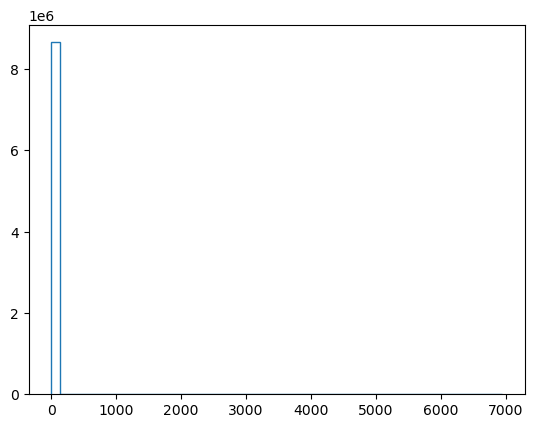

In [28]:
plt.hist(mu_sig_sq, bins = 50, histtype='step')

In [19]:
df_pm_stats.shape

(2635776, 10)

In [20]:
df_pm_stats

,pix,G_bin,bil_bin,dist_bin,number,mean_pmra,mean_pmdec,var_pmra,var_pmdec,var_pmradec
0,0.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,1.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,3.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,4.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2635771,3067.0,22.0,3.0,10000.0,0.0,NaN,NaN,NaN,NaN,NaN
2635772,3068.0,22.0,3.0,10000.0,0.0,NaN,NaN,NaN,NaN,NaN
2635773,3069.0,22.0,3.0,10000.0,0.0,NaN,NaN,NaN,NaN,NaN
2635774,3070.0,22.0,3.0,10000.0,0.0,NaN,NaN,NaN,NaN,NaN


In [21]:
a = df_pm_stats['number'].to_numpy()

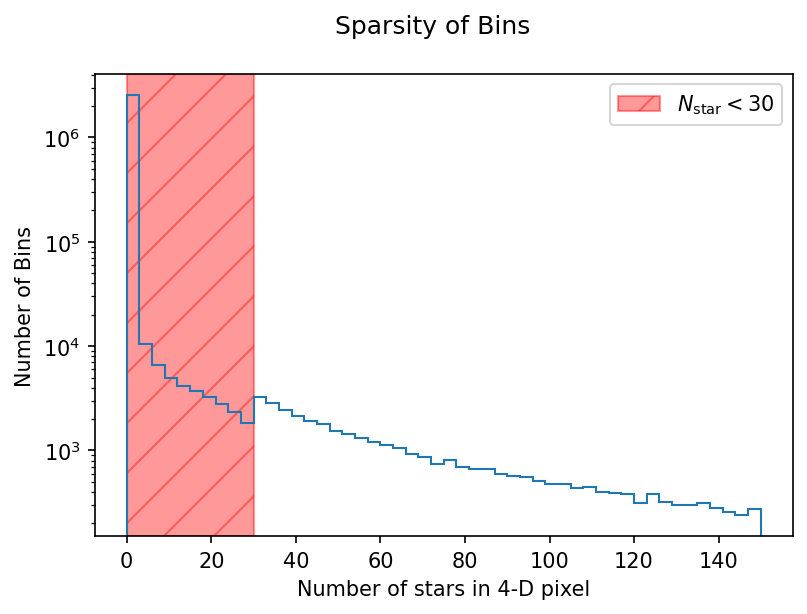

In [22]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)

plt.hist(a[a<150], bins = 50, log = True, histtype='step')
ax.set_xlabel(r'Number of stars in 4-D pixel')
ax.set_ylabel(r'Number of Bins')
#plt.axvline(x=30, color='r', linestyle='--', label = r'$N_{\mathrm{min}} = 30$')
ax.axvspan(0, 30 , alpha=0.4, color='red', label = r'$N_{\mathrm{star}} < 30$', hatch = '/')

plt.legend()
fig.suptitle(r'Sparsity of Bins')

plt.show()

# Tests

## Bin definition

In [32]:
### Fix error with distance bins. Since we approximate the distace pdf with a gaussian, some stars end up having a distribution that extend to negative distances.

from bin_defs import *

hp.nside2npix(hp.order2nside(n)), len(bins_dist), len(bins_G), len(bins_bil)

(3072, 7, 18, 11)

In [34]:
hp.pixelfunc.nside2resol(hp.order2nside(n))/degree

3.6645188392718997

In [46]:
bins_dist

array([     0.        ,   1000.        ,   1778.27941004,   3162.27766017,   5623.4132519 ,  10000.        , 200000.        ])

In [89]:
bins_G = np.concatenate([[5], np.arange(13,23,1)]) 

In [10]:
bins_dist

array([     0.        ,   1000.        ,   1778.27941004,   3162.27766017,
         5623.4132519 ,  10000.        , 200000.        ])

In [11]:
bins_G

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22])

In [11]:
bins_bil

array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3])

In [12]:
(hp.nside2npix(hp.order2nside(n))-1) * (len(bins_dist)-1) * (len(bins_G)-1) * (len(bins_bil)-1)

2634918

In [61]:
hp.nside2resol(2**4, arcmin = True)*arcmin/degree

3.6645188392718997

In [51]:
4*np.pi/(hp.nside2resol(2**n)**2)

3071.9999999999995

## Bin assignement

In [31]:
# assign to healpix bins
fac_source_id = 2**(59-2*n)
q_pix = np.floor(df_back['source_id'].to_numpy() / fac_source_id).astype(int)
bins_pix = np.arange(np.min(np.unique(q_pix)), np.max(np.unique(q_pix))+2,1) # should be +2 to include sources in the last bin
q_bin_pix = np.digitize(q_pix, bins_pix) - 1  # need to access the histogram matrix elements

NameError: name 'n' is not defined

In [174]:
### assign to G bins
# assign to G bins
bg_G = df_back['phot_g_mean_mag'].to_numpy()
q_bin_G = np.digitize(bg_G, bins_G) - 1  

In [175]:
# assign to radial bins
## necessary columns
fg_ra = df_fore['ra'].to_numpy()
fg_dec = df_fore['dec'].to_numpy()
bg_ra = df_back['ra'].to_numpy()
bg_dec = df_back['dec'].to_numpy()
## bil separation vectors
l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)
l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2
## bin definitions
q_bil = np.sqrt(l_bilnormsq)/arcsec
q_bin_bil = np.digitize(q_bil, bins_bil) - 1   

In [176]:
### deterministic distance bin assignement - for testing
q_bin_dist = np.digitize(df_back['dist'].to_numpy(), bins_dist) - 1   

prob_dist = np.zeros((len(df_back),len(bins_dist)-1))
for i in range(len(bins_dist)-1):    
    prob_dist[q_bin_dist==i, i] = 1

In [177]:
# probabilistic assignment to distance bins
bg_dist = df_back['dist'].to_numpy()
# bg error is average of posterior width in each direction
bg_dist_error = df_back['dist_error'].to_numpy()

prob_dist_neg = np.nan * np.ones((len(df_back),len(bins_dist_neg)-1))
for i in range(len(bins_dist_neg)-1):
    x1_list = (bins_dist_neg[i]-bg_dist)/bg_dist_error/np.sqrt(2)
    x2_list = (bins_dist_neg[i+1]-bg_dist)/bg_dist_error/np.sqrt(2)
    prob_dist_neg[:,i] = 0.5*(erf(x2_list)-erf(x1_list))

In [178]:
### Check that the total probability adds up to 1
prob_test = np.sum(prob_dist_neg, axis=1)
len(prob_test[np.abs(prob_test-1)>0.001])

0

In [179]:
### Add the probability in the negative distance bin to the first non negative bin
prob_dist = np.nan * np.ones((len(df_back),len(bins_dist)-1))
prob_dist = np.copy(prob_dist_neg[:, 1:])
prob_dist[:, 0] += prob_dist_neg[:, 0]

In [180]:
### Check that the addition has been done correctly
aa = prob_dist[:, 0]
bb = prob_dist_neg[:, 0]+prob_dist_neg[:, 1]
aa[aa>0]/bb[aa>0]

array([1., 1., 1., ..., 1., 1., 1.])

In [181]:
### Check that the total probability adds up to 1
prob_test = np.sum(prob_dist, axis=1)
len(prob_test[np.abs(prob_test-1)>0.1])

0

## Remove stars in sparse bins - deterministic distance bin assignement

In [97]:
hist_prob_2 = np.histogramdd(np.array([q_pix, bg_G, q_bil, bg_dist]).T, bins=(bins_pix, bins_G, bins_bil, bins_dist), range=None, density=None, weights=None)[0].T
hist_prob_2.shape

(6, 10, 10, 3072)

In [99]:
hist_prob_2_copy = np.copy(hist_prob_2)
hist_prob_2_copy[hist_prob_2_copy<=30] = np.nan
stars_count_nan = hist_prob_2_copy[q_bin_dist, q_bin_bil, q_bin_G, q_bin_pix]

In [101]:
stars_count = hist_prob_2[q_bin_dist, q_bin_bil, q_bin_G, q_bin_pix]
len(stars_count[stars_count>30])/len(stars_count)

0.8503368304486877

Text(0, 0.5, 'Occurence')

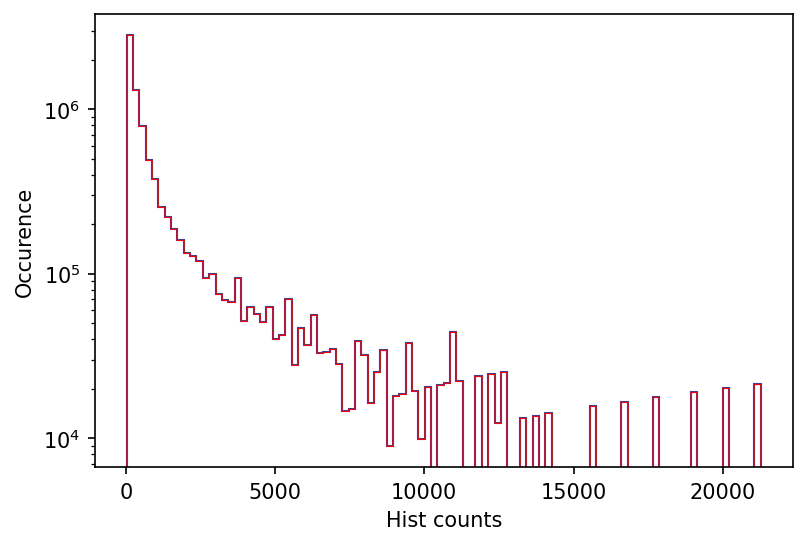

In [102]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
ax.hist(stars_count[stars_count>30], log = True,  density = False, bins = 100, histtype='step', color = 'darkslateblue')
ax.hist(stars_count_nan, log = True,  density = False, bins = 100, histtype='step', color = 'red', linewidth=0.5)
ax.set_xlabel(r'Hist counts')
ax.set_ylabel(r'Occurence')
#ax.set_xscale('log')
#ax.set_xlim(0.5, 14000)
#plt.show()

## Remove stars in sparse bins

In [167]:
th_count = 30; prob_sparse_th = 0.2

In [187]:
### histogram of summed probabilities
hist_prob = stats.binned_statistic_dd([q_bil, bg_G, q_pix], np.transpose(prob_dist), bins=[bins_bil, bins_G, bins_pix], statistic='sum')[0] 
hist_prob.shape

(6, 10, 10, 2919)

In [188]:
len(q_bil), sum(hist_prob.flatten())

(8370659, 8370658.999999987)

In [189]:
### per each star, get the count of the corresponding bin (all the counts for the distance bins)
count_prob = hist_prob[:, q_bin_bil, q_bin_G, q_bin_pix].T
count_prob.shape

### per each star, sum over the counts of the distance bins
count_tot = np.sum(count_prob*prob_dist, axis=1)
count_tot.shape

(8370659,)

In [190]:
len(count_tot[count_tot>th_count])

8214353

In [191]:
### Find all the stars whose distance probability support is mostly in spare bins. Remove stars with more than 20% probability in sparse bins

hist_prob_copy = np.copy(hist_prob)
hist_prob_copy[hist_prob<th_count] = 1
hist_prob_copy[hist_prob>=th_count] = 0
count_prob_sparse = hist_prob_copy[:, q_bin_bil, q_bin_G, q_bin_pix].T

prob_in_sparse_bin = np.sum(count_prob_sparse*prob_dist, axis=1)

len(prob_in_sparse_bin[prob_in_sparse_bin < prob_sparse_th])

8103491

In [168]:
### Find all the stars whose distance probability support is mostly in spare bins. Remove stars with more than 20% probability in sparse bins

hist_prob_copy = np.copy(hist_prob)
hist_prob_copy[hist_prob<th_count] = 1
hist_prob_copy[hist_prob>=th_count] = 0
count_prob_sparse = hist_prob_copy[:, q_bin_bil, q_bin_G, q_bin_pix].T

prob_in_sparse_bin = np.sum(count_prob_sparse*prob_dist, axis=1)

len(prob_in_sparse_bin[prob_in_sparse_bin < prob_sparse_th])

8370659

In [170]:
### Select only stars whose 80% of probability does not fall in sparse bins

df_back = df_back[prob_in_sparse_bin < prob_sparse_th]
df_fore = df_fore[prob_in_sparse_bin < prob_sparse_th]

Text(0, 0.5, 'Occurence')

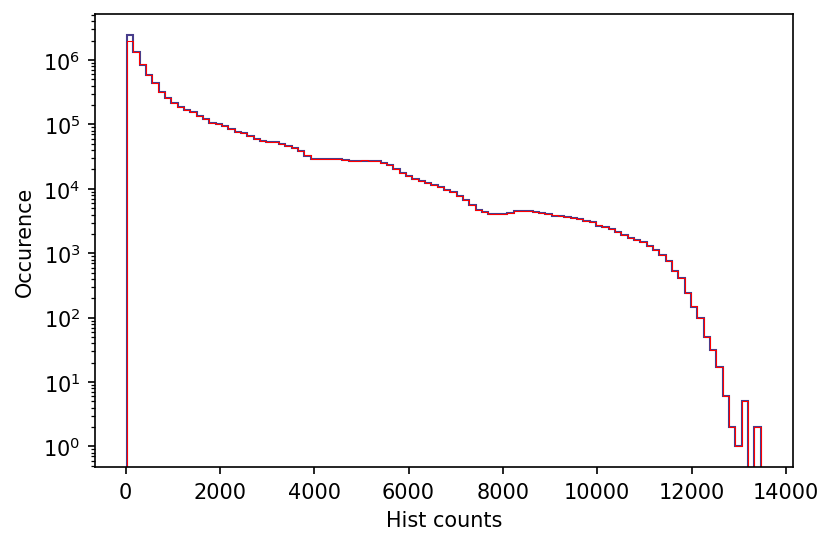

In [169]:
fig, ax = plt.subplots(1,1, figsize=(6,4),dpi=150)
ax.hist(count_tot[count_tot>th_count], log = True,  density = False, bins = 100, histtype='step', color = 'darkslateblue')
ax.hist(count_tot[prob_in_sparse_bin < prob_sparse_th], log = True,  density = False, bins = 100, histtype='step', color = 'red', linewidth=0.5)
ax.set_xlabel(r'Hist counts')
ax.set_ylabel(r'Occurence')
#ax.set_xscale('log')
#ax.set_xlim(0.5, 14000)
#plt.show()

# New procedure

## Read in cleaned sample

In [2]:
### Read in the data files for the background and foreground stars
df_back = pd.read_csv(DataDir+'bg_ruwe_dist.csv', 
                      usecols = ['source_id', 'ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'pmra_pmdec_corr', 'pmra_eff_error', 'pmdec_eff_error', 'pmra_pmdec_eff_corr', 
                                 'parallax', 'parallax_error', 'pmra_sub', 'pmdec_sub', 'phot_g_mean_mag', 'ruwe'])
df_fore = pd.read_csv(DataDir+'fg_ruwe_dist.csv', 
                      usecols = ['source_id', 'ra', 'dec', 'pmra', 'pmdec','pmra_error', 'pmdec_error', 'parallax', 'parallax_error', 'phot_g_mean_mag', 'ruwe'])
len(df_back), len(df_fore)

(10448136, 10448136)

In [3]:
### Read in the data files for the Bailer-Jones distances
back_dist = pd.read_csv(DataDir+'bg_distances.csv', usecols = ['0', '1', '2', '3'])
fore_dist = pd.read_csv(DataDir+'fg_distances.csv', usecols = ['0', '1', '2', '3'])
len(back_dist), len(fore_dist)

(10448136, 10448136)

In [4]:
df_back['dist_50'] = back_dist['1']
df_back['dist_14'] = back_dist['2']
df_back['dist_86'] = back_dist['3']

In [5]:
### Estimate of a symmetric error
df_back['dist_error'] = ((df_back['dist_50'].to_numpy() - df_back['dist_14'].to_numpy()) + 
                         (df_back['dist_86'].to_numpy() - df_back['dist_50'].to_numpy())) / 2

In [6]:
df_fore['dist_50'] = fore_dist['1']
df_fore['dist_14'] = fore_dist['2']
df_fore['dist_86'] = fore_dist['3']

## Import bin definitions

In [7]:
from bin_defs import *

hp.nside2npix(hp.order2nside(n)), len(bins_dist), len(bins_G), len(bins_bil)

(3072, 7, 18, 11)

In [10]:
(hp.nside2npix(hp.order2nside(n))-1) * (len(bins_dist)-1) * (len(bins_G)-1) * (len(bins_bil)-1)

3132420

## Function definition

In [8]:
def fn_pm_stats(df_fore, df_back, th_count=30, prob_sparse_th = 0.2, n_sigma_out = 3, final_call=False): ### if return_tab=True returns the tab without pm outliers, else returns the data frame with stats 

    # assign to healpix bins
    q_pix = np.floor(df_back['source_id'].to_numpy() / fac_source_id).astype(int)
    bins_pix = np.arange(np.min(np.unique(q_pix)), np.max(np.unique(q_pix))+2,1) # should be +2 to include sources in the last bin
    q_bin_pix = np.digitize(q_pix, bins_pix) - 1  # need to access the histogram matrix elements

    ### assign to G bins
    # assign to G bins
    bg_G = df_back['phot_g_mean_mag'].to_numpy()
    q_bin_G = np.digitize(bg_G, bins_G) - 1  

    # assign to radial bins
    ## necessary columns
    fg_ra = df_fore['ra'].to_numpy()
    fg_dec = df_fore['dec'].to_numpy()
    bg_ra = df_back['ra'].to_numpy()
    bg_dec = df_back['dec'].to_numpy()
    ## bil separation vectors
    l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)
    l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2
    ## bin definitions
    q_bil = np.sqrt(l_bilnormsq)/arcsec
    q_bin_bil = np.digitize(q_bil, bins_bil) - 1   

    # probabilistic assignment to distance bins
    bg_dist = df_back['dist_50'].to_numpy()
    # bg error is average of posterior width in each direction
    bg_dist_error = df_back['dist_error'].to_numpy()
    
    prob_dist_neg = np.nan * np.ones((len(df_back),len(bins_dist_neg)-1))
    for i in range(len(bins_dist_neg)-1):
        x1_list = (bins_dist_neg[i]-bg_dist)/bg_dist_error/np.sqrt(2)
        x2_list = (bins_dist_neg[i+1]-bg_dist)/bg_dist_error/np.sqrt(2)
        prob_dist_neg[:,i] = 0.5*(erf(x2_list)-erf(x1_list))
    
    ### Add the probability in the negative distance bin to the first non negative bin
    prob_dist = np.nan * np.ones((len(df_back),len(bins_dist)-1))
    prob_dist = np.copy(prob_dist_neg[:, 1:])
    prob_dist[:, 0] += prob_dist_neg[:, 0]

    bg_pmra = df_back['pmra'].to_numpy(); bg_pmdec = df_back['pmdec'].to_numpy(); bg_parallax = df_back['parallax'].to_numpy();
    ### histogram of summed probabilities
    hist_prob = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix], np.transpose(prob_dist), bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] 
    ### histogram of average pmra weighted by probabilities
    hist_pmra = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * bg_pmra, bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] #sum first in each bin
    hist_pmra = hist_pmra / (hist_prob + 1e-20) #then divide by number in each bin
    hist_pmdec = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * bg_pmdec, bins=[bins_bil, bins_G, bins_pix], statistic='sum')[0] #sum first in each bin
    hist_pmdec = hist_pmdec / (hist_prob + 1e-20) #then divide by number in each bin
    ### histogram of average parallax weighted by probabilities
    hist_parallax = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * bg_parallax, bins=[bins_bil, bins_G, bins_pix], statistic='sum')[0] #sum first in each bin
    hist_parallax = hist_parallax / (hist_prob + 1e-20) #then divide by number in each bin
    
    ### For each star, get the mean pm and parallax of the corresponding bin
    mean_pmra = hist_pmra[:, q_bin_bil, q_bin_G, q_bin_pix].T; mean_pmdec = hist_pmdec[:, q_bin_bil, q_bin_G, q_bin_pix].T
    mean_parallax = hist_parallax[:, q_bin_bil, q_bin_G, q_bin_pix].T

    ### histogram of pm variance weighted by dist bin probabilities
    hist_pmra_var = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * (mean_pmra.T - bg_pmra)**2,
                                                    bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] #sum first in each bin
    hist_pmra_var = hist_pmra_var / (hist_prob - 1 + 1e-20) # the estimator should have a -1 (this matches for example var() computed with panda's groupy)
    hist_pmdec_var = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * (mean_pmdec.T - bg_pmdec)**2,
                                                    bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] #sum first in each bin
    hist_pmdec_var = hist_pmdec_var / (hist_prob - 1 + 1e-20) 
    hist_pmradec_var = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * (mean_pmra.T - bg_pmra) * (mean_pmdec.T - bg_pmdec),
                                                        bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] #sum first in each bin
    hist_pmradec_var = hist_pmradec_var / (hist_prob - 1 + 1e-20) 
    hist_parallax_var = sp.stats.binned_statistic_dd([q_bil, bg_G, q_pix],np.transpose(prob_dist) * (mean_parallax.T - bg_parallax)**2, 
                                                     bins=[bins_bil, bins_G, bins_pix],statistic='sum')[0] #sum first in each bin
    hist_parallax_var = hist_parallax_var / (hist_prob - 1 + 1e-20) 
    
    ### set to nan bins where there are too few stars
    hist_pmra[hist_prob < th_count] = np.nan; hist_pmdec[hist_prob < th_count] = np.nan; hist_parallax[hist_prob < th_count] = np.nan
    hist_pmra_var[hist_prob < th_count] = np.nan; hist_pmdec_var[hist_prob < th_count] = np.nan; hist_pmradec_var[hist_prob < th_count] = np.nan
    hist_parallax_var[hist_prob < th_count] = np.nan

    ### For each star, get the pm mean and variance of the corresponding bin (after excluding the low count bins)
    mean_pmra = hist_pmra[:, q_bin_bil, q_bin_G, q_bin_pix].T; mean_pmdec = hist_pmdec[:, q_bin_bil, q_bin_G, q_bin_pix].T
    mean_parallax = hist_parallax[:, q_bin_bil, q_bin_G, q_bin_pix].T
    var_pmra = hist_pmra_var[:, q_bin_bil, q_bin_G, q_bin_pix].T; var_pmdec = hist_pmdec_var[:, q_bin_bil, q_bin_G, q_bin_pix].T; var_pmradec = hist_pmradec_var[:, q_bin_bil, q_bin_G, q_bin_pix].T;    
    var_parallax = hist_parallax_var[:, q_bin_bil, q_bin_G, q_bin_pix].T
    
    ###  Get the mean and var for each star
    tab_sum_pw = np.sum(prob_dist, axis=1, where=(~np.isnan(mean_pmra)))  # sum of the dist weights for each star using only bins with enough statistics 
    tab_mean_pmra = np.sum(np.nan_to_num(mean_pmra*prob_dist), axis=1)/(tab_sum_pw + 1e-20)
    tab_mean_pmdec = np.sum(np.nan_to_num(mean_pmdec*prob_dist), axis=1)/(tab_sum_pw + 1e-20)
    tab_mean_parallax = np.sum(np.nan_to_num(mean_parallax*prob_dist), axis=1)/(tab_sum_pw + 1e-20)
    tab_var_pmra = np.sum(np.nan_to_num(var_pmra*prob_dist), axis=1)/(tab_sum_pw + 1e-20)
    tab_var_pmdec = np.sum(np.nan_to_num(var_pmdec*prob_dist), axis=1)/(tab_sum_pw + 1e-20)
    tab_var_pmradec = np.sum(np.nan_to_num(var_pmradec*prob_dist), axis=1)/(tab_sum_pw + 1e-20)   
    tab_var_parallax = np.sum(np.nan_to_num(var_parallax*prob_dist), axis=1)/(tab_sum_pw + 1e-20)   
    
    ### Find all the stars whose distance probability support is mostly in spare bins. Remove stars with more than 20% probability in sparse bins
    hist_prob_copy = np.copy(hist_prob)
    hist_prob_copy[hist_prob<th_count] = 1
    hist_prob_copy[hist_prob>=th_count] = 0
    count_prob_sparse = hist_prob_copy[:, q_bin_bil, q_bin_G, q_bin_pix].T

    prob_in_sparse_bin = np.sum(count_prob_sparse*prob_dist, axis=1)
    good_bins = prob_in_sparse_bin < prob_sparse_th
    
    len_bg = len(df_back)
    out_frac=(1-len(prob_in_sparse_bin[good_bins])/len_bg);        
    print('Iter '+str(iter_n)+' -- fraction of stars in sparse bins: '+str(out_frac*100)[:8]+' %')
    
    tab_mean_pmra = tab_mean_pmra[good_bins]; tab_mean_pmdec = tab_mean_pmdec[good_bins]; tab_mean_parallax = tab_mean_parallax[good_bins]
    tab_var_pmra = tab_var_pmra[good_bins]; tab_var_pmdec = tab_var_pmdec[good_bins]; tab_var_pmradec = tab_var_pmradec[good_bins]
    tab_var_parallax = tab_var_parallax[good_bins]
    
    df_fore = df_fore.iloc[good_bins]; df_back = df_back.iloc[good_bins]
    
    ### subtracted pm and inverse covariance for outlier removal
    pm_sub = np.array([df_back['pmra'].to_numpy()-tab_mean_pmra, df_back['pmdec'].to_numpy()-tab_mean_pmdec]).T
    parallax_sub = df_back['parallax'].to_numpy()-tab_mean_parallax

    if final_call==False: ### remove outliers
        inv_cov_pm = np.linalg.inv(np.array([[tab_var_pmra, tab_var_pmradec], [tab_var_pmradec, tab_var_pmdec]]).T)
        mu_over_sigma_sq = inv_cov_pm[:, 0, 0]*pm_sub[:, 0]**2 + inv_cov_pm[:, 1, 1]*pm_sub[:, 1]**2 + 2*inv_cov_pm[:, 0, 1]*pm_sub[:, 0]*pm_sub[:, 1]

        len_bg = len(df_back)
        df_fore = df_fore.iloc[( (mu_over_sigma_sq < n_sigma_out**2) & (parallax_sub**2/tab_var_parallax < n_sigma_out**2) )]
        df_back = df_back.iloc[( (mu_over_sigma_sq < n_sigma_out**2) & (parallax_sub**2/tab_var_parallax < n_sigma_out**2) )]
        out_frac=(1-len(df_back)/len_bg);        
        print('Iter '+str(iter_n)+' -- fraction of outliers removed: '+str(out_frac*100)[:8]+' %')
        
        return df_fore, df_back
            
    else: ### add columns corresponding to subtracted pm motion and effective variance 
        df_back['pmra_sub_new'] = pm_sub[:, 0]; df_back['pmdec_sub_new'] = pm_sub[:, 1]; df_back['parallax_sub_new'] = parallax_sub
        
        df_back['pmra_eff_error_new'] = np.sqrt(tab_var_pmra)
        df_back['pmdec_eff_error_new'] = np.sqrt(tab_var_pmdec)

        df_back['pmra_pmdec_eff_corr_new'] = tab_var_pmradec/(np.sqrt(tab_var_pmra)*np.sqrt(tab_var_pmdec))
        
        df_back['parallax_eff_error_new'] = np.sqrt(tab_var_parallax)
        
        return df_fore, df_back

## Run

In [9]:
iter_n=0
out_frac=1
n_iter = 10 # each iteration around 1 minutes
n_sigma_out = 3
th_count = 30
prob_sparse_th = 0.2

while (iter_n<n_iter) & (out_frac>1E-5):
    df_fore_n, df_back_n = fn_pm_stats(df_fore, df_back, th_count, prob_sparse_th, n_sigma_out, final_call=False)
    df_fore, df_back = df_fore_n, df_back_n
    iter_n += 1; 

Iter 0 -- fraction of stars in sparse bins: 19.88473 %
Iter 0 -- fraction of outliers removed: 3.320342 %
Iter 1 -- fraction of stars in sparse bins: 3.706228 %
Iter 1 -- fraction of outliers removed: 2.335316 %
Iter 2 -- fraction of stars in sparse bins: 1.124508 %
Iter 2 -- fraction of outliers removed: 1.110652 %
Iter 3 -- fraction of stars in sparse bins: 0.266194 %
Iter 3 -- fraction of outliers removed: 0.507900 %
Iter 4 -- fraction of stars in sparse bins: 0.093377 %
Iter 4 -- fraction of outliers removed: 0.231837 %
Iter 5 -- fraction of stars in sparse bins: 0.051793 %
Iter 5 -- fraction of outliers removed: 0.107935 %
Iter 6 -- fraction of stars in sparse bins: 0.018398 %
Iter 6 -- fraction of outliers removed: 0.050878 %
Iter 7 -- fraction of stars in sparse bins: 0.006809 %
Iter 7 -- fraction of outliers removed: 0.024119 %
Iter 8 -- fraction of stars in sparse bins: 0.002778 %
Iter 8 -- fraction of outliers removed: 0.011987 %
Iter 9 -- fraction of stars in sparse bins: 0.

In [2]:
10448136*0.75

7836102.0

In [10]:
### Do the subtraction one last time without removing the outliers
df_fore_n, df_back_n = fn_pm_stats(df_fore, df_back, th_count, prob_sparse_th, n_sigma_out, final_call=True)
df_fore, df_back = df_fore_n, df_back_n

Iter 10 -- fraction of stars in sparse bins: 0.001594 %


<ipython-input-8-cd57858cf411>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_back['pmra_sub_new'] = pm_sub[:, 0]; df_back['pmdec_sub_new'] = pm_sub[:, 1]; df_back['parallax_sub_new'] = parallax_sub
<ipython-input-8-cd57858cf411>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_back['pmra_eff_error_new'] = np.sqrt(tab_var_pmra)
<ipython-input-8-cd57858cf411>:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [41]:
### Save the result

df_fore.to_csv(DataDir+'fg_subtracted.csv', index=False, chunksize=100000)

In [42]:
df_back.to_csv(DataDir+'bg_subtracted.csv', index=False, chunksize=100000)

In [11]:
df_back

,source_id,ra,dec,pmra,pmdec,pmra_error,pmdec_error,pmra_pmdec_corr,parallax,parallax_error,...,dist_14,dist_86,dist_error,pmra_sub_new,pmdec_sub_new,parallax_sub_new,pmra_eff_error_new,pmdec_eff_error_new,pmra_pmdec_eff_corr_new,parallax_eff_error_new
77837,407652079258216832,26.833258,51.855765,-4.064927,-1.565365,0.126139,0.116540,0.012693,0.406816,0.124430,...,1938.6178,3334.8035,698.09285,-2.706098,-1.160469,0.093985,1.910270,1.552029,-0.151126,0.080468
77850,407670053694081536,26.529999,52.070850,-2.963004,-0.583585,0.075206,0.069984,0.045255,0.351316,0.075596,...,2163.2551,3112.2837,474.51430,-1.590190,-0.191498,0.031630,1.937944,1.571456,-0.157471,0.081716
77883,407745301525056256,28.135469,52.558146,-1.199981,-1.201087,0.088220,0.075072,-0.079274,0.324604,0.076862,...,2442.0657,3889.4458,723.69005,0.119845,-0.760469,0.030890,1.830878,1.496515,-0.131461,0.076881
77921,407818041090608384,27.248774,52.956444,-0.443197,-0.612761,0.097763,0.084193,-0.033119,0.162303,0.086288,...,3299.5427,5740.7360,1220.59665,0.805635,-0.107121,-0.096613,1.676750,1.389788,-0.085938,0.069880
77945,407870164811431552,26.579393,52.453189,-0.758300,-0.242869,0.131261,0.101988,-0.218260,0.151688,0.119610,...,3105.4836,5697.6235,1296.06995,0.501472,0.252752,-0.112590,1.701408,1.406761,-0.093967,0.071004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10421972,6764395645195995008,286.702925,-24.943808,-6.547409,-4.257561,0.435546,0.345680,-0.025354,-0.632005,0.367965,...,4055.6035,9337.4480,2640.92225,-4.269628,0.700850,-0.350562,2.329336,2.878635,0.236486,0.315528
10421989,6764400459856491904,286.959903,-24.814410,0.726159,-6.218973,0.333150,0.304717,0.349956,0.266297,0.286263,...,3067.2144,6921.4260,1927.10580,2.330365,-1.682934,0.546917,2.767953,2.761677,0.117668,0.303018
10422002,6764403792752241536,286.750590,-24.768030,0.947705,-4.734969,0.214560,0.177042,0.157865,-0.067881,0.190301,...,4696.9014,9857.3540,2580.22630,2.691867,-0.220999,-0.077797,2.465034,2.690545,0.052801,0.154764
10422003,6764403792752241664,286.749851,-24.768231,-1.230452,-6.258204,0.258761,0.218863,0.186150,0.121720,0.229431,...,3815.6404,10095.1720,3139.76580,0.434695,-1.973859,0.157605,2.539053,2.654047,0.117623,0.193855


In [12]:
df_fore

,source_id,ra,dec,pmra,pmdec,pmra_error,pmdec_error,parallax,parallax_error,phot_g_mean_mag,ruwe,dist_50,dist_14,dist_86
77837,407652083551512960,26.833340,51.856516,12.067780,-10.596260,0.561367,0.466178,1.719803,0.519281,20.008286,1.059188,804.16980,566.88280,1088.25060
77850,407670053697191936,26.531067,52.071347,-2.015311,-2.023124,0.026102,0.025137,0.599444,0.026578,15.117724,1.039073,1569.07780,1506.92970,1628.10730
77883,407745301522158208,28.136469,52.557591,9.808310,-5.353896,0.753849,0.592664,2.413656,0.569169,20.097862,1.083858,483.05066,372.60986,643.85443
77921,407818036795554432,27.247790,52.955936,-0.140986,-7.115295,0.315361,0.298617,1.275553,0.308394,19.543024,1.027695,893.59406,708.77530,1202.46510
77945,407870164813793408,26.578290,52.453678,45.055729,-14.663389,0.060869,0.048567,2.899897,0.055866,16.423018,1.004972,340.61853,334.55960,347.35630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10421972,6764395649492439424,286.702410,-24.944334,0.300947,-4.543128,0.688743,0.526774,1.848124,0.564692,19.952463,0.917467,732.37250,523.12976,1028.10010
10421989,6764400455558270336,286.960385,-24.815074,-1.896755,-9.439440,0.080350,0.071460,1.183686,0.072429,17.161087,0.995648,837.06464,790.42236,881.72485
10422002,6764403788452938880,286.750486,-24.768752,0.259481,-0.306208,0.075398,0.062280,0.994623,0.066277,16.874763,0.962140,990.98020,920.72797,1075.33960
10422003,6764403788452938880,286.750486,-24.768752,0.259481,-0.306208,0.075398,0.062280,0.994623,0.066277,16.874763,0.962140,990.98020,920.72797,1075.33960


## Plots

Text(0.5, 0.98, 'New Subtraction')

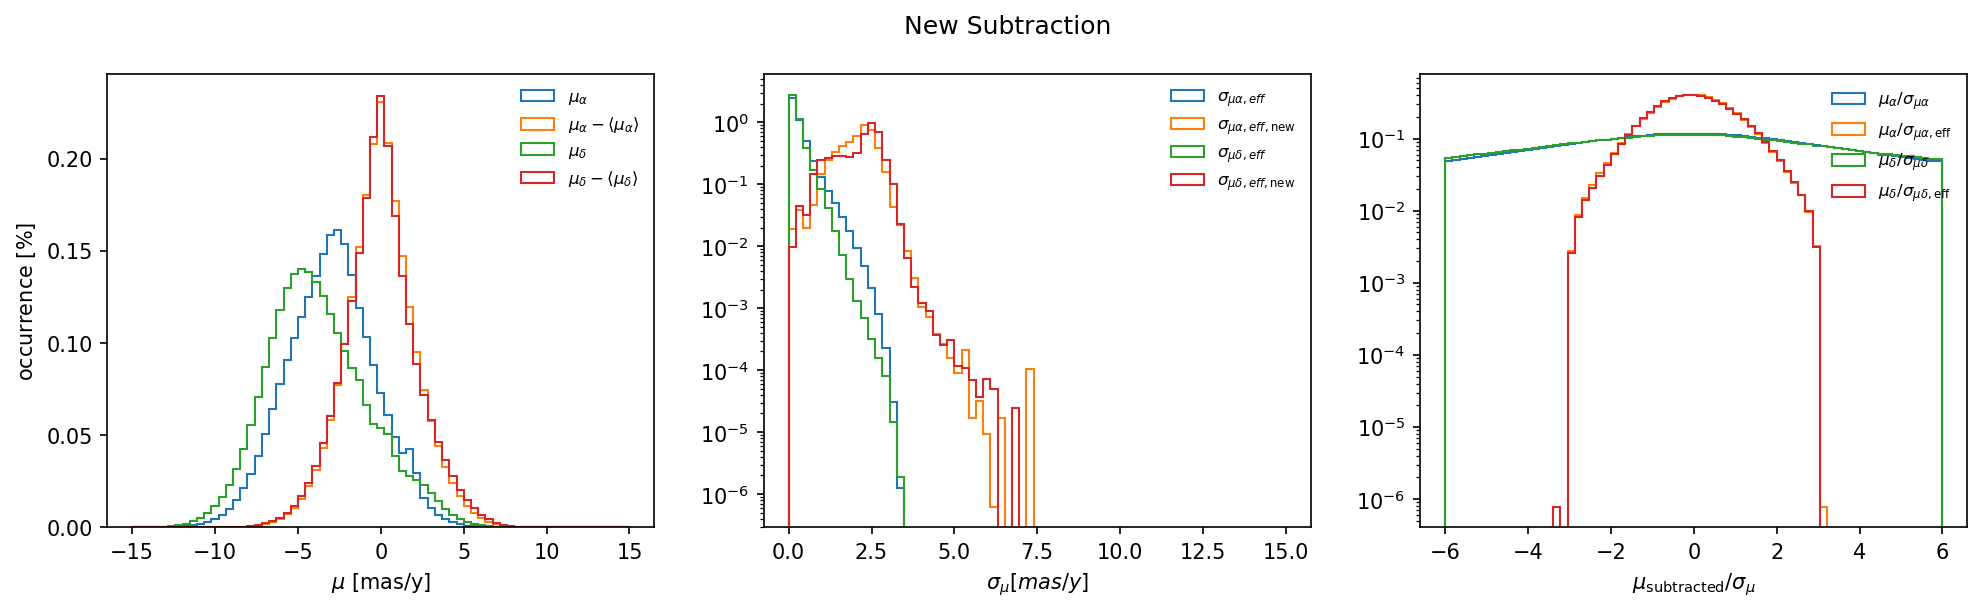

In [13]:
fig,ax = plt.subplots(1,3,figsize=(16,4), dpi = 150)

xmax, nbins = 15, 70
ax[0].hist(df_back['pmra'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(df_back['pmra_sub_new'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(df_back['pmdec'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(df_back['pmdec_sub_new'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].legend([r'$\mu_\alpha$', r'$\mu_\alpha - \langle \mu_\alpha \rangle$', '$\mu_\delta$', r'$\mu_\delta - \langle \mu_\delta \rangle$'], loc='upper right', fontsize = 8, frameon=False);
ax[0].set_xlabel(r'$\mu$ [mas/y]'); ax[0].set_ylabel(r'occurrence [$\%$]');
#ax.set_title(r'Velocity template for '+str(len(tau_list[map_count>min_count]))+' subsets', fontsize = 16);

xmax, nbins = 15, 70
ax[1].hist(df_back['pmra_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(df_back['pmra_eff_error_new'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(df_back['pmdec_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(df_back['pmdec_eff_error_new'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
#ax[1].set_ylim(0.001, 3)

#ax[1].legend([r'$\sigma_{\mu\alpha, \mathrm{Gaia}}$', r'$\sigma_{\mu\alpha, eff, \mathrm{new}}$', r'$\sigma_{\mu\delta, \mathrm{Gaia}}$', r'$\sigma_{\mu\delta, eff, \mathrm{new}}$'], 
#             loc='upper right', fontsize = 8, frameon=False);
ax[1].legend([r'$\sigma_{\mu\alpha, eff}$', r'$\sigma_{\mu\alpha, eff, \mathrm{new}}$', 
              r'$\sigma_{\mu\delta, eff}$', r'$\sigma_{\mu\delta, eff, \mathrm{new}}$'], 
             loc='upper right', fontsize = 8, frameon=False);
ax[1].set_xlabel(r'$\sigma_\mu [mas/y]$'); #ax[1].set_ylabel(r'occurrence [$\%$]');

xmax, nbins = 6, 70
ax[2].hist(df_back['pmra_sub_new']/df_back['pmra_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(df_back['pmra_sub_new']/df_back['pmra_eff_error_new'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(df_back['pmdec_sub_new']/df_back['pmdec_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(df_back['pmdec_sub_new']/df_back['pmdec_eff_error_new'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].legend([r'$\mu_{\alpha}/\sigma_{\mu\alpha}$', r'$\mu_{\alpha}/\sigma_{\mu\alpha, \mathrm{eff}}$', 
              r'$\mu_{\delta}/\sigma_{\mu\delta}$', r'$\mu_{\delta}/\sigma_{\mu\delta, \mathrm{eff}}$'], loc='upper right', fontsize = 8, frameon=False);
ax[2].set_xlabel(r'$\mu_\mathrm{subtracted}/\sigma_\mu$'); #ax[2].set_ylabel(r'occurrence [$\%$]');

#plt.tight_layout()
plt.suptitle('New Subtraction')
#fig.savefig(FigDir+'pm_stats.pdf')

Text(0.5, 0.98, 'New Subtraction')

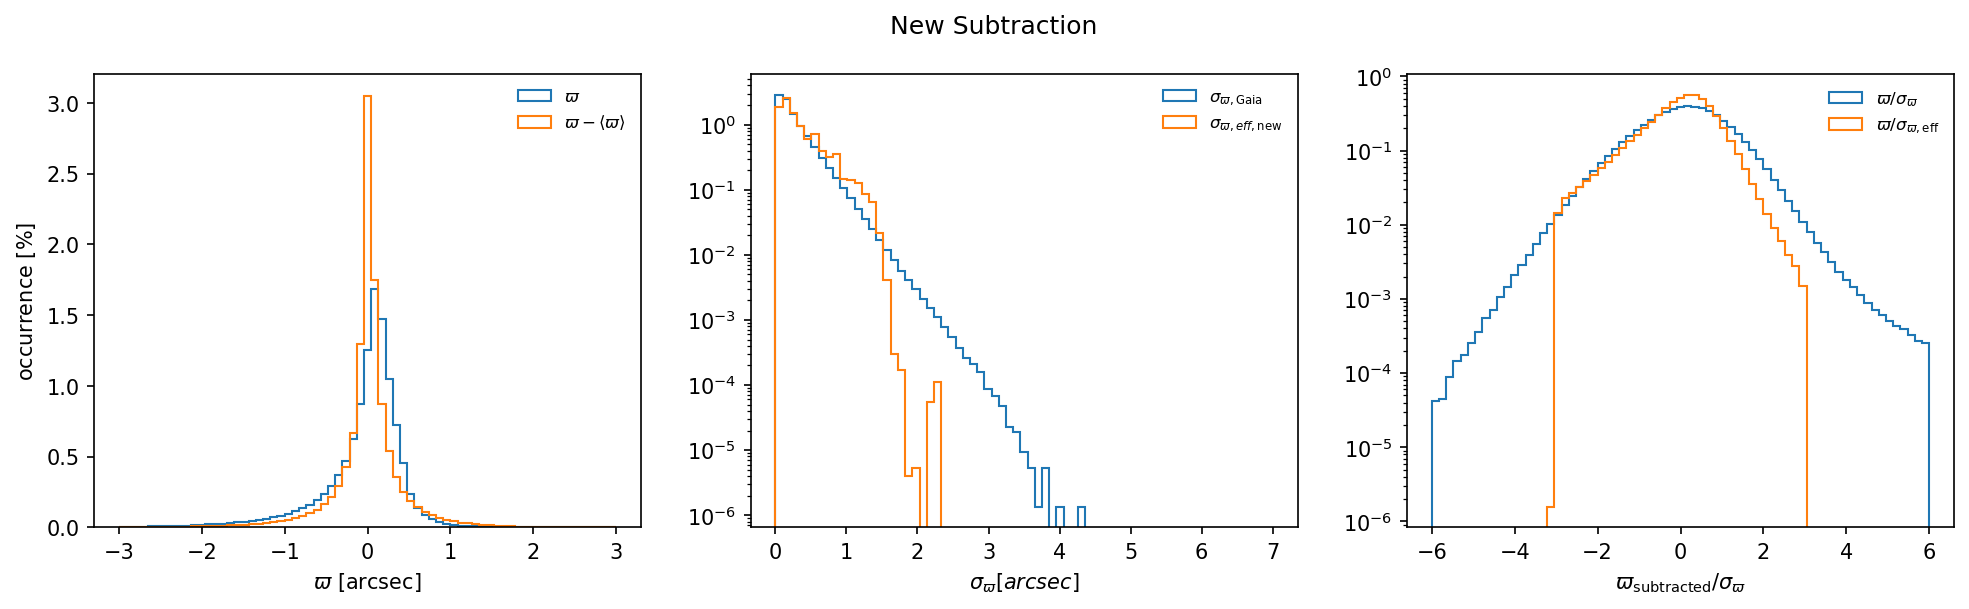

In [17]:
fig,ax = plt.subplots(1,3,figsize=(16,4), dpi = 150)

xmax, nbins = 3, 70
ax[0].hist(df_back['parallax'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(df_back['parallax_sub_new'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].legend([r'$\varpi$', r'$\varpi - \langle \varpi \rangle$'], loc='upper right', fontsize = 8, frameon=False);
ax[0].set_xlabel(r'$\varpi$ [arcsec]'); ax[0].set_ylabel(r'occurrence [$\%$]');
#ax.set_title(r'Velocity template for '+str(len(tau_list[map_count>min_count]))+' subsets', fontsize = 16);

xmax, nbins = 7, 70
ax[1].hist(df_back['parallax_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(df_back['parallax_eff_error_new'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].legend([r'$\sigma_{\varpi, \mathrm{Gaia}}$', r'$\sigma_{\varpi, eff, \mathrm{new}}$'], 
             loc='upper right', fontsize = 8, frameon=False);
ax[1].set_xlabel(r'$\sigma_\varpi [arcsec]$'); 

xmax, nbins = 6, 70
ax[2].hist(df_back['parallax_sub_new']/df_back['parallax_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(df_back['parallax_sub_new']/df_back['parallax_eff_error_new'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].legend([r'$\varpi/\sigma_{\varpi}$', r'$\varpi/\sigma_{\varpi, \mathrm{eff}}$'], loc='upper right', fontsize = 8, frameon=False);
ax[2].set_xlabel(r'$\varpi_\mathrm{subtracted}/\sigma_\varpi$'); 

#plt.tight_layout()
plt.suptitle('New Subtraction')
#fig.savefig(FigDir+'pm_stats.pdf')

In [18]:
## covariance matrix with the new effective variances
def fn_cov_pm_eff(df):
    """
    Given a panda data frame df, returns the effective covariance matrix for (pmra, pmdec).
    """
    return np.array([[df['pmra_eff_error_new']**2, df['pmra_pmdec_eff_corr_new']*df['pmra_eff_error_new']*df['pmdec_eff_error_new']], 
                     [df['pmra_pmdec_eff_corr_new']*df['pmra_eff_error_new']*df['pmdec_eff_error_new'], df['pmdec_eff_error_new']**2]]).T

In [19]:
inv_cov_pm = np.linalg.inv(fn_cov_pm_eff(df_back))
pm_sub = np.array([df_back['pmra_sub_new'].to_numpy(), df_back['pmdec_sub_new'].to_numpy()]).T

mu_over_sigma_sq = (inv_cov_pm[:, 0, 0]*pm_sub[:, 0]**2 + inv_cov_pm[:, 1, 1]*pm_sub[:, 1]**2 + 
                    2*inv_cov_pm[:, 0, 1]*pm_sub[:, 0]*pm_sub[:, 1])

In [20]:
min(mu_over_sigma_sq), max(mu_over_sigma_sq)

(3.6449755377310347e-07, 12.489561088569307)

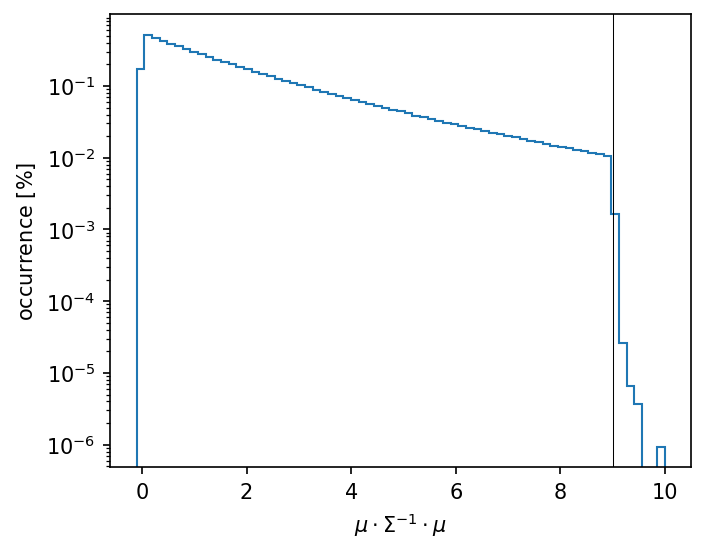

In [21]:
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi = 150)

ax.hist(mu_over_sigma_sq, bins=np.linspace(-0.1, 10, 70), log=True, density=True, histtype='step');
ax.set_xlabel(r'$\mu \cdot \Sigma^{-1} \cdot \mu$ '); ax.set_ylabel(r'occurrence [$\%$]');
ax.axvline(9, color='k', linewidth=0.5)

### Plotting the variances

In [22]:
# assign to radial bins
## necessary columns
fg_ra = df_fore['ra'].to_numpy()
fg_dec = df_fore['dec'].to_numpy()
bg_ra = df_back['ra'].to_numpy()
bg_dec = df_back['dec'].to_numpy()
## bil separation vectors
l_bilvec = fn_angular_sep(fg_ra*degree, fg_dec*degree, bg_ra*degree, bg_dec*degree)
l_bilnormsq = l_bilvec[:, 0]**2 + l_bilvec[:, 1]**2
## bin definitions
q_bil = np.sqrt(l_bilnormsq)/arcsec
q_bin_bil = np.digitize(q_bil, bins_bil) - 1

In [47]:
bins_bil

array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ])

In [48]:
min(q_bil), max(q_bil)

(0.6000153125570444, 2.9999999422979227)

In [23]:
direction = df_back['pmra_sub_new']

mean_pmra = np.zeros(len(bins_bil))
var_pmra = np.zeros(len(bins_bil))

for i_b in tqdm(range(len(bins_bil))):
    direction_i_b = direction[q_bin_bil == i_b]
    mean_pmra[i_b] = np.mean(direction_i_b) 
    var_pmra[i_b] = np.var(direction_i_b) 

100%|██████████| 11/11 [00:00<00:00, 21.54it/s]


In [24]:
direction = df_back['pmdec_sub_new']

mean_pmdec = np.zeros(len(bins_bil))
var_pmdec = np.zeros(len(bins_bil))

for i_b in tqdm(range(len(bins_bil))):
    direction_i_b = direction[q_bin_bil == i_b]
    mean_pmdec[i_b] = np.mean(direction_i_b) 
    var_pmdec[i_b] = np.var(direction_i_b) 

100%|██████████| 11/11 [00:00<00:00, 26.78it/s]


In [25]:
eff_pmra = df_back['pmra_eff_error_new']
eff_pmdec = df_back['pmdec_eff_error_new']

var_pm = np.zeros(len(bins_bil))

for i_b in tqdm(range(len(bins_bil))):
    eff_pmra_i_b = eff_pmra[q_bin_bil == i_b]
    eff_pmdec_i_b = eff_pmdec[q_bin_bil == i_b]
    var_pm[i_b] = np.mean(eff_pmra_i_b**2 + eff_pmdec_i_b**2)

100%|██████████| 11/11 [00:00<00:00, 12.94it/s]


In [26]:
eff_pmra = df_back['pmra_eff_error']
eff_pmdec = df_back['pmdec_eff_error']

var_pm_old = np.zeros(len(bins_bil))

for i_b in tqdm(range(len(bins_bil))):
    eff_pmra_i_b = eff_pmra[q_bin_bil == i_b]
    eff_pmdec_i_b = eff_pmdec[q_bin_bil == i_b]
    var_pm_old[i_b] = np.mean(eff_pmra_i_b**2 + eff_pmdec_i_b**2)

100%|██████████| 11/11 [00:00<00:00, 12.96it/s]


In [27]:
direction = df_back['parallax_sub_new']

mean_parallax = np.zeros(len(bins_bil))
var_parallax = np.zeros(len(bins_bil))

for i_b in tqdm(range(len(bins_bil))):
    direction_i_b = direction[q_bin_bil == i_b]
    mean_parallax[i_b] = np.mean(direction_i_b) 
    var_parallax[i_b] = np.var(direction_i_b) 

100%|██████████| 11/11 [00:00<00:00, 22.12it/s]


In [32]:
var

array([        nan, 15.41906832, 13.29750438, 10.26411139,  9.5200891 ,
        9.54142066,  9.47751182,  9.43148313,  9.34536989,  9.29984638,
               nan,         nan])

In [57]:
var_pm_old

array([       nan,        nan, 6.57739366, 5.40305418, 5.02743929,
       5.009933  , 5.01981862, 5.02761508, 5.02225626, 5.02524889,
              nan])

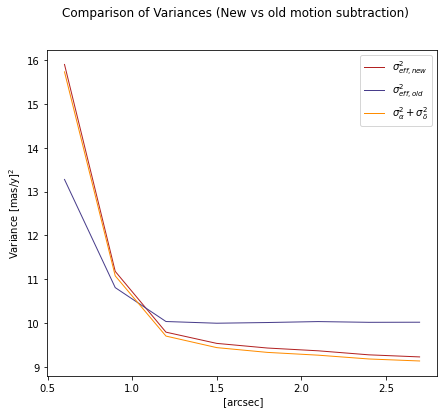

In [33]:
fig, ax = plt.subplots(1,1, figsize=(7,6) )#,dpi=300)
ax.plot(bins_bil, var_pm, label = r'$\sigma_{eff, new}^2$', lw = 1, color = 'firebrick')
ax.plot(bins_bil, var_pm_old, label = r'$\sigma_{eff, old}^2$', lw = 1, color = 'darkslateblue')
ax.plot(bins_bil, var_pmra + var_pmdec, label = r'$\sigma_{\alpha}^2 + \sigma_{\delta}^2$', lw = 1, color = 'darkorange')

ax.set_ylabel(r'Variance [mas/y]$^2$')
ax.set_xlabel(r' [arcsec]')
fig.suptitle('Comparison of Variances (New vs old motion subtraction)')
ax.legend()

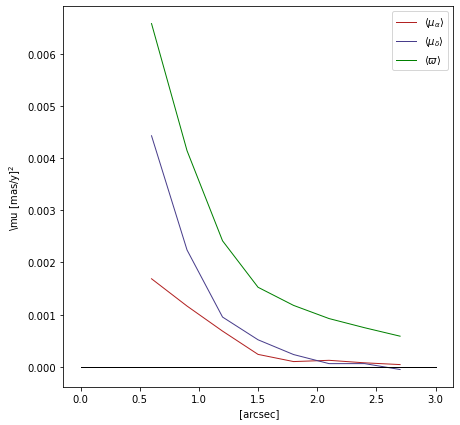

In [40]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.plot(bins_bil, mean_pmra, label = r'$\langle \mu_{\alpha} \rangle$', lw = 1, color = 'firebrick')
ax.plot(bins_bil, mean_pmdec, label = r'$\langle \mu_{\delta} \rangle$', lw = 1, color = 'darkslateblue')
ax.plot(bins_bil, mean_parallax, label = r'$\langle \varpi \rangle$', lw = 1, color = 'green')
ax.plot(bins_bil, np.zeros(len(bins_bil)), label = r'', lw = 1, color = 'k')

ax.set_ylabel(r'\mu [mas/y]$^2$')
ax.set_xlabel(r' [arcsec]');
#fig.suptitle('Comparison of Variances (New vs old motion subtraction)');
ax.legend()

In [35]:
mean_parallax/var_parallax

array([       nan,        nan, 0.0136625 , 0.01101397, 0.00930055,
       0.00766586, 0.00616189, 0.00485983, 0.00403203, 0.00322416,
              nan])